In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

注意一点：图片数据输入要求是4维的！(batch, height, width, channels) —— 这里Mnist是单通道图，需要人为补一个channel

In [6]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [7]:
# 拓维：
x_train = np.expand_dims( x_train, -1 )  # 最后维度的拓展
x_test = np.expand_dims( x_test, -1 )
# 查看：
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### 1. 同样的加噪声：

In [8]:
# 数值归一化：这里从numpy变成了tensor！
x_train = tf.cast( x_train, tf.float32 ) / 255
x_test = tf.cast( x_test, tf.float32 ) / 255

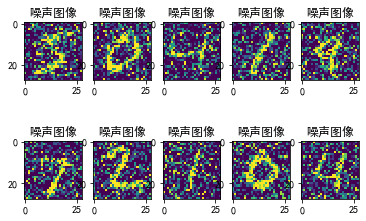

In [9]:
# 加噪声：
factor = 0.5
# 加随机噪声：
x_train_noise = x_train + factor*np.random.normal( size = x_train.shape )
x_test_noise = x_test + factor*np.random.normal( size = x_test.shape )
# 再次归一化：
x_train_noise = np.clip( x_train_noise, 0., 1. )  # 小于0归为0，大于1归为1
x_test_noise = np.clip( x_test_noise, 0., 1. )
# 画图：
# 画图展示：
n = 5
for x in range(n):
    plt.subplot(2, n, x + 1)
    plt.imshow( x_train_noise[x].reshape(28,28) )  # 返回为单通道
    plt.title('噪声图像')
    plt.subplot(2, 5, x + n + 1)
    plt.imshow( x_test_noise[x].reshape(28,28) )
    plt.title('噪声图像')

### 2. 网络搭建：

In [10]:
# 网络搭建与训练：
input = tf.keras.layers.Input( shape = (28,28,1) )  # 变！
# 压缩encode：下采样
x = tf.keras.layers.Conv2D( 16, (3,3), activation = 'relu', padding = 'same')(input)  # 28 x 28 x 16
x = tf.keras.layers.MaxPooling2D()(x) # 小一倍：14 x 14 x 16
x = tf.keras.layers.Conv2D( 32, (3,3), activation = 'relu', padding = 'same')(x)  # 14 x 14 x 32
x = tf.keras.layers.MaxPooling2D()(x) # 小一倍：7 x 7 x 32
# 解压缩decode：上采样
x = tf.keras.layers.Conv2DTranspose(16, (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)  # 大一倍：14 x 14 x 16
x = tf.keras.layers.Conv2DTranspose(1, (3,3), strides = (2,2), activation = 'sigmoid', padding = 'same')(x)  # 大一倍：28 x 28 x 1
# 模型创建：
model = tf.keras.Model( inputs = input, outputs = x )

In [11]:
# 下面编译和训练都是一样的：
model.compile(
    optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001),  # 优化器实例：这里可以自定义一些参数！！！
    loss = 'mse',  # 类似于L2范数
    metrics = ['acc'] 
)

In [12]:
# 训练：
history = model.fit(
    x_train_noise,  # 换成带噪声的数据！
    x_train,        # “标签”：还是原始好数据！
    epochs = 5,
    batch_size = 256,
    shuffle = True,  
    validation_data = (x_test_noise, x_test)  # 同理！
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 30s 502us/sample - loss: 0.1072 - acc: 0.7974 - val_loss: 0.0514 - val_acc: 0.8003
Epoch 2/5
60000/60000 [==============================] - 26s 430us/sample - loss: 0.0305 - acc: 0.8046 - val_loss: 0.0220 - val_acc: 0.8082
Epoch 3/5
60000/60000 [==============================] - 24s 405us/sample - loss: 0.0205 - acc: 0.8098 - val_loss: 0.0188 - val_acc: 0.8099
Epoch 4/5
60000/60000 [==============================] - 24s 396us/sample - loss: 0.0183 - acc: 0.8109 - val_loss: 0.0174 - val_acc: 0.8103
Epoch 5/5
60000/60000 [==============================] - 24s 397us/sample - loss: 0.0172 - acc: 0.8113 - val_loss: 0.0167 - val_acc: 0.8103


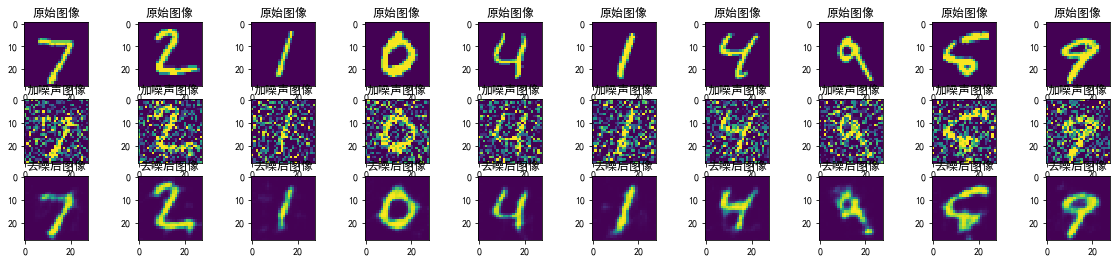

In [13]:
# 绘图：
# 预测：
x_test_pred = model.predict( x_test_noise ) 
# 画图：10张垂向对比
plt.figure( figsize = (20,4) )
n = 10
for x in range(n):
    plt.subplot(3, n, x + 1)
    plt.imshow( x_test[x].numpy().reshape(28,28) )
    plt.title('原始图像')
    plt.subplot(3, n, x + n + 1)
    plt.imshow( x_test_noise[x].reshape(28,28) )
    plt.title('加噪声图像')
    plt.subplot(3, n, x + n*2 + 1)
    plt.imshow( x_test_pred[x].reshape(28,28) )
    plt.title('去噪后图像')